# Optimizing the Delivery of Packages
This last jupyter notebook aims at finding the shortest paths between destinations of the devlivery drones. We want to minimize the time of flight of the drones, which is important becuase of the limited autonomy of the drones and their slow charging.

If a drone begins at, for example, site 1, it is required to deliver packages to other destinations, and then return to the starting site 1. Each destination site needs to be visited exactly once and none can be skipped. The objective is to find the sequence of sites which being and end at site 1 such that the journey is minimized. This is essentially the **travelling salesman problem**, a well known NP-complete problem.

## Preliminary Work
The function `generate_map()` randomly places `N` sites on a 2D map of size $L_x\times L_y$.

In [1]:
import random
import tkinter as tk
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [2]:
def generate_map(Lx,Ly,N):
    L=[]
    while N>0:
        T=[(random.randint(0,Lx),random.randint(0,Ly))]
        if not T in L:
            L+=T
            N-=1
    return(L)

sites = generate_map(840, 480, 8)
print(sites)

[(831, 75), (566, 103), (144, 307), (483, 179), (486, 269), (106, 453), (459, 384), (203, 389)]


In [3]:
def draw_map(sites,canvas):
    for i in range(len(sites)-1):
        canvas.create_line(sites[i],sites[i+1],fill="green")
        canvas.create_line(sites[i], (sites[i][0]+5, sites[i][1]+5),fill="black",width=4)
        
    canvas.create_text(sites[0][0]+5, sites[0][1]+15, text="0")
    
window = tk.Tk()
canvas = tk.Canvas(window, width=860, height=500)
draw_map(sites,canvas)
canvas.pack()
window.mainloop()

![Randomly generated sites for a map](images/random_map.jpg)

In [4]:
def distance(sites,i,j):
    try:
        return(round(((sites[j][0]-sites[i][0])**2+(sites[j][1]-sites[i][1])**2)**(1/2)))
    except IndexError:
        print(i, j)
        print(sites)
        raise Exception
    
def total_distance(parcours):
    S=distance(parcours,0,-1)
    for i in range(len(parcours)-1):
        S+=distance(parcours,i,i+1)
    return(S)

print(total_distance(sites))

2927


## Greedy Algorithm - Nearest Neighbor Heuristic
The greedy algorithm starts from the first site and for each of the $(N-1)$ iterations we fly tot he next nearest location, before finally returning back to the starting location.

In [5]:
def generate_distance_matrix(sites):
    '''returns a matrix where M[i,j] is the distance between site i and j
    '''
    n=len(sites)
    M=[ [0 for i in range(n)] for j in range(n)]
    for i in range(n):
        for j in range(i):
            d=distance(sites,i,j)
            M[i][j]=d
            M[j][i]=d
    return(M)

print(generate_distance_matrix(sites))

[[0, 266, 725, 363, 396, 818, 484, 702], [266, 0, 469, 113, 184, 578, 301, 462], [725, 469, 0, 362, 344, 151, 324, 101], [363, 113, 362, 0, 90, 466, 206, 350], [396, 184, 344, 90, 0, 422, 118, 307], [818, 578, 151, 466, 422, 0, 360, 116], [484, 301, 324, 206, 118, 360, 0, 256], [702, 462, 101, 350, 307, 116, 256, 0]]


In [6]:
def nearest_neighbor(sites):
    M=generate_distance_matrix(sites)
    n=len(M[0])
    L=[sites[0]]
    current=0
    
    while len(L)<len(sites):
        
        for i in range(n):              # on in terdit que le plus proche voisin soit current
            M[i][current]=sys.maxsize
        
        nextindex=M[current].index(min(M[current]))
        L+=[sites[nextindex]]
            
        current=nextindex
    return(L)
    
window = tk.Tk()
canvas = tk.Canvas(window, width=860, height=500)
draw_map(nearest_neighbor(sites),canvas)
canvas.pack()
window.mainloop()

![Greedy algorithm results](images/map_greedy.jpg)
The complexity of the above algorithm is $\mathcal{O}(n^2)$ where $n$ is the number of sites.

Number of sites: 100 , Calculation time: 0.018966200000001265
Number of sites: 125 , Calculation time: 0.01955149999999861
Number of sites: 150 , Calculation time: 0.022667000000005544
Number of sites: 175 , Calculation time: 0.028084399999997345
Number of sites: 200 , Calculation time: 0.03800369999999731
Number of sites: 225 , Calculation time: 0.04512799999999828
Number of sites: 250 , Calculation time: 0.05273620000000534
Number of sites: 275 , Calculation time: 0.0686370000000025
Number of sites: 300 , Calculation time: 0.07606409999999642
Number of sites: 325 , Calculation time: 0.09032039999999597
Number of sites: 350 , Calculation time: 0.10669379999999506
Number of sites: 375 , Calculation time: 0.11888340000000142
Number of sites: 400 , Calculation time: 0.14402439999999928
Number of sites: 425 , Calculation time: 0.14897210000000172
Number of sites: 450 , Calculation time: 0.17764139999999884
Number of sites: 475 , Calculation time: 0.18351279999999548


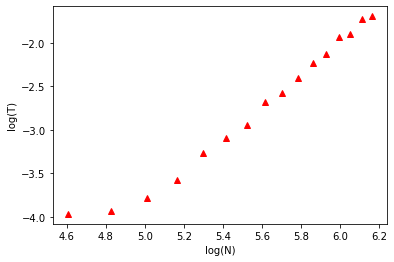

In [7]:
N_list = np.arange(100,500,25)
Time_list = []

for N in N_list:
   c = generate_map(840, 480, N)

   ti = time.perf_counter()
   nearest_neighbor(c)
   ts = time.perf_counter()

   print("Number of sites:", N, ", Calculation time:", ts - ti)
   Time_list.append(math.log(ts - ti))

#print N_list, time_list
plt.xlabel('log(N)')
plt.ylabel('log(T)')
plt.plot(np.log(N_list), Time_list, 'r^')
plt.show()

The gradient of the above curve is approximately 2, which agrees with the complexity of $n^2$.

## Exhaustive Search Algorithm
A brute force method which goes through all possible paths and keeps the one which is the shortest. The complexity of such a algorithm would be $\mathcal{O}(n!)$

In [8]:
path_list = []

def all_paths(start_path, remaining_sites):
    if len(remaining_sites)==1:
        global path_list
        path_list+=[start_path + remaining_sites]
        return
    for site in range(len(remaining_sites)):
        all_paths(start_path+[remaining_sites[site]], remaining_sites[:site]+remaining_sites[site+1:])
        
all_paths([], sites)
# print(path_list)

In [9]:
shortest = sys.maxsize

def shortest_path(start_path, remaining_sites):
    if len(remaining_sites)==1:
        global path_list
        global shortest
        if(total_distance(start_path+remaining_sites) < shortest):
            path_list=start_path + remaining_sites
            shortest=total_distance(path_list)
        return
    for site in range(len(remaining_sites)):
        shortest_path(start_path+[remaining_sites[site]], remaining_sites[:site]+remaining_sites[site+1:])

def brute_force(sites):
    shortest_path([], sites)
    return(path_list)

print(brute_force(sites))
window = tk.Tk()
canvas = tk.Canvas(window, width=860, height=500)
draw_map(brute_force(sites),canvas)
canvas.pack()
window.mainloop()

[(831, 75), (566, 103), (483, 179), (144, 307), (106, 453), (203, 389), (459, 384), (486, 269)]


![best path from exhaustive search](images/best_path.jpg)

Number of sites: 5 , calculation time: 0.0021205000000037444
Number of sites: 6 , calculation time: 0.014943700000003446
Number of sites: 7 , calculation time: 0.06718379999999513
Number of sites: 8 , calculation time: 0.47264979999999923
Number of sites: 9 , calculation time: 4.462043000000008
Number of sites: 10 , calculation time: 54.167457799999994


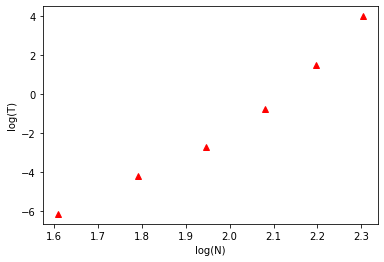

In [10]:
N_list = [5,6,7,8,9,10]
Time_list = []

for N in N_list:
   c = generate_map(840, 480, N)

   ti = time.perf_counter()
   brute_force(c)
   ts = time.perf_counter()

   print("Number of sites:", N, ", calculation time:", ts - ti)
   Time_list.append(math.log(ts - ti))

#print N_list, time_list
plt.xlabel('log(N)')
plt.ylabel('log(T)')
plt.plot(np.log(N_list), Time_list, 'r^')
plt.show()

## Branch and Bound Algorithm
Given the enormous time it takes to search all possible paths, the **branch and bound algorithm** aims to eliminate all the solutions that we known will be bad solutions. For a given map, we can calculate the minimum bound for all paths. We can consider the length of a path as the sum of the weights on each movement from site to site. If we take the 2 nearest neighbors for every site, then the average of these two distances forms the lower bound. We can be sure that the best path is atleast greater than this average. Mathematically, for each site $i$, we note $(a_i, b_i)$ the distances to two nearest neighbors and then calculate the sum $\frac{1}{2}\sum_i (a_i +b_i)$.

Once we decide to go to a stop, this has a consequence on the inferior bound, and we recalculate this bound after each stop. The branch and bound algorithm will recursively explore the possible set of paths and save in memory the best path it encounters. As soon as a branch incurs a cost greater than the current best path, this branch is then abandoned, without going any further. As a result the algorithm does not explore any of the sub branches from that branch as it knows for sure that they will all be atleast the same bound.

The `min_bound()` calculates the minimum bound for a given path.

In [11]:
def min_bound(start_path, remaining_sites):
    min_bound = 0

    remaining_sites_copy = remaining_sites[:]
    remaining_sites_copy.append(start_path[0])
    remaining_sites_copy.append(start_path[-1])
    distance_matrix = generate_distance_matrix(remaining_sites_copy)

    l = len(distance_matrix)
    for i in range(l-2):                                # trouve les deux plus petites distances entre sites restants et sites restants bis
        min1, min2 = sys.maxsize, sys.maxsize
        for j in range(l):
            if j != i:
                distance_i_j = distance_matrix[i][j]
                if distance_i_j <= min1:
                    min2 = min1
                    min1 = distance_i_j
                elif distance_i_j < min2:
                    min2 = distance_i_j
        min_bound += min1 + min2

    for i in range(l-2, l):                     # trouve la plus petite distance entre entame [0], [-1] et sites restants
        min = sys.maxsize
        for j in range(l-2):
            distance_i_j = distance_matrix[i][j]
            if distance_i_j < min:
                min = distance_i_j
        min_bound += min

    for i in range(0,len(start_path)-1):               # trouve la distance totales des points déjà visités
        min_bound += distance(start_path, i, i+1)
    for i in range(1,len(start_path)):
        min_bound += distance(start_path, i-1, i)

    return math.ceil(min_bound/2)

In [12]:
# illustrative example [a, b, c ,d ,e] centered around 'e'
a, b, c, d, e = (3, 4), (6, 4), (9, 4), (3, 0), (0, 0)

# we choose site (b,d)
print(min_bound([b, d], [a, c, e])) # must be 20

## choose a -> e -> c
print(min_bound([a, e, c], [b, d])) # must be 26

20
26


In [13]:
best_bound= sys.maxsize
    
def shortest_path_branch_bound(start_path, remaining_sites):
    if len(remaining_sites)==1:
        global path_list
        path_list=start_path + remaining_sites
        return
    for site in range(len(remaining_sites)):
        if(min_bound(start_path, remaining_sites) < best_bound):
            shortest_path_branch_bound(start_path+[remaining_sites[site]], remaining_sites[:site]+remaining_sites[site+1:])

def branch_bound(sites):
    shortest_path_branch_bound([sites[0]], sites[1:])
    return(path_list)

In [14]:
shortest_bb = branch_bound(sites)
window = tk.Tk()
canvas = tk.Canvas(window, width=860, height=500)
draw_map(shortest_bb, canvas)
canvas.pack()
window.mainloop()
print("Brute Force: ", total_distance(brute_force(sites)), ", Branch and Bound: ", total_distance(shortest_bb))

Brute Force:  2927 , Branch and Bound:  2927


In [15]:
N_max = 7
window = tk.Tk()
canvas = tk.Canvas(window, width=860, height=500)

for N in range(4, N_max+1):
   c = generate_map(840, 480, N)
   shortest1 = branch_bound(c)
   shortest2 = brute_force(c)
   if total_distance(shortest1) != total_distance(shortest2):
       draw_map(shortest1, canvas)
       draw_map(shortest2, canvas)
       print(c)
       break
   else:
       print('OK')

canvas.pack()
window.mainloop()

OK
OK
OK
OK


Number of sites: 5 , Calculation time: 0.0026585999999895193
Number of sites: 6 , Calculation time: 0.008084200000013197
Number of sites: 7 , Calculation time: 0.05076069999998367
Number of sites: 8 , Calculation time: 0.29727969999999004
Number of sites: 9 , Calculation time: 2.390601800000013
Number of sites: 10 , Calculation time: 23.6946078


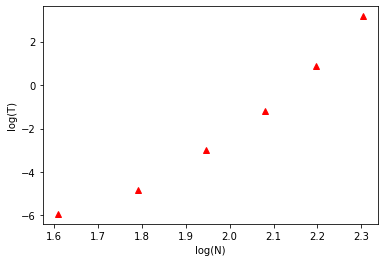

In [16]:
N_list = [5,6,7,8,9,10]
Time_list = []

for N in N_list:
   c = generate_map(840, 480, N)

   ti = time.perf_counter()
   branch_bound(c)
   ts = time.perf_counter()

   print("Number of sites:", N, ", Calculation time:", ts - ti)
   Time_list.append(math.log(ts - ti))

#print N_list, time_list
plt.xlabel('log(N)')
plt.ylabel('log(T)')
plt.plot(np.log(N_list), Time_list, 'r^')
plt.show()

## Local Optimization Algorithm "2-opt"
The local optimization algorithm **2-opt** allows us to improve the paths by deleting paths that cross each other. This is done by inversing the order of visiting these nodes.
![2-opt algorithm](images/2opt.jpg)

In [17]:
def two_opt(sites):
    n = len(sites)
    for i in range(n-3):
        for j in range(i+2, n-1):
            if (distance(sites, i, i+1) + distance(sites, j, j+1) > distance(sites, i, j) + distance(sites, i+1,j+1)):
                L1=sites[:i+1]
                L2=sites[i+1:j+1]
                L2_inv=L2[::-1]
                L3=sites[j+1:]
                sites = L1 + L2_inv + L3
    assert(n==len(sites)) # sanity check
    return sites

In [18]:
N_list = [5,6,7,8,9,10]
for N in N_list:
    c = generate_map(840, 480, N)
    bb_length = total_distance(branch_bound(c))
    to_length = total_distance(two_opt(c))
    print("For N:", N, ", length of branch and bound:", bb_length, ", length for two_opt:", to_length)

For N: 5 , length of branch and bound: 1655 , length for two_opt: 1655
For N: 6 , length of branch and bound: 1494 , length for two_opt: 1367
For N: 7 , length of branch and bound: 1647 , length for two_opt: 1471
For N: 8 , length of branch and bound: 2609 , length for two_opt: 1618
For N: 9 , length of branch and bound: 3248 , length for two_opt: 2187
For N: 10 , length of branch and bound: 2805 , length for two_opt: 2098
For N: 11 , length of branch and bound: 4369 , length for two_opt: 2648


Nombre de sites: 5 , temps de calcul: 2.5899999968714837e-05
Nombre de sites: 6 , temps de calcul: 4.8800000001847366e-05
Nombre de sites: 7 , temps de calcul: 7.130000000188375e-05
Nombre de sites: 8 , temps de calcul: 9.190000002945453e-05
Nombre de sites: 9 , temps de calcul: 0.00012010000000373111
Nombre de sites: 10 , temps de calcul: 0.0001527000000010048


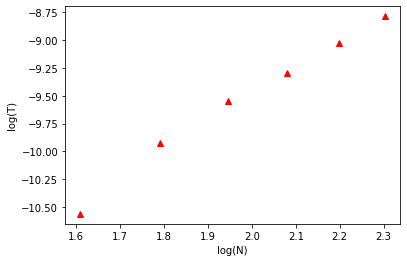

In [19]:
N_list = [5,6,7,8,9,10]
Time_list = []

for N in N_list:
   c = generate_map(840, 480, N)

   ti = time.perf_counter()
   two_opt(c)
   ts = time.perf_counter()

   print("Nombre de sites:", N, ", temps de calcul:", ts - ti)
   Time_list.append(math.log(ts - ti))

#print N_list, time_list
plt.xlabel('log(N)')
plt.ylabel('log(T)')
plt.plot(np.log(N_list), Time_list, 'r^')
plt.show()